# This is Bing's Version

# Imports and reading data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Imports for Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from keras.optimizers import Adam

ModuleNotFoundError: No module named 'keras'

# Functions

In [ ]:
def get_metrics(y_true, y_predict, print_scores = True):
    matrix_def = [['tn','fp'], ['fn','tp']]
    matrix = confusion_matrix(y_true, y_predict)
    tn, fp, fn, tp = matrix.ravel()
    accuracy = (tp+tn)/(tn+fp+fn+tp)
    misclass = 1-accuracy
    sensitivity = tp/(tp+fn)
    specificity = tn/(tn+fp)
    precision = tp/(tp+fp)
    if print_scores:
        print('Matrix Definition')
        print(np.array(matrix_def))
        print('')
        print('Confusion Matrix')
        print(matrix)
        print('')
        print('METRICS')
        print(f'accuracy: {accuracy}')
        print(f'misclass: {misclass}')
        print(f'sensitivity: {sensitivity}')
        print(f'specificity: {specificity}')
    else:
        return accuracy, misclass, sensitivity, specificity, precision

In [ ]:
!ls west_nile/west_nile/input/weather.csv

In [ ]:
df = pd.read_csv('../west_nile/west_nile/input/train.csv')
df_test = pd.read_csv('../west_nile/west_nile/input/test.csv')

In [2]:
spray_df = pd.read_csv('..//west_nile/west_nile/input/spray.csv')

In [4]:
spray_df.Date.value_counts()

2013-08-15    2668
2013-08-29    2302
2013-07-17    2202
2011-09-07    2114
2013-07-25    1607
2013-08-22    1587
2013-08-08    1195
2013-09-05     924
2013-08-16     141
2011-08-29      95
Name: Date, dtype: int64

In [ ]:
weather_df = pd.read_csv('../west_nile/west_nile/input/weather.csv')

# Train Cleaning: 

## Total mosquitos per trap:

In [ ]:
cols = [col for col in df.columns if col not in ['NumMosquitos', 'WnvPresent']]
df = df.groupby(cols, as_index=False).sum()
df['WnvPresent'] = (df.WnvPresent>0).astype(int)

In [ ]:
df[['Trap', 'Date', 'Species']].duplicated(keep=False).sum()

# Spray Cleaning:

##  Splitting Date into year/month/day:

In [ ]:
spray_df['year'] = spray_df.Date.str[:4]
spray_df['month'] = spray_df.Date.str[5:7]
spray_df['day'] = spray_df.Date.str[-2:]

# EDA:

In [ ]:

mapdata = np.loadtxt("../west_nile/west_nile/input/mapdata_copyright_openstreetmap_contributors.txt")
traps = df[['Date', 'Trap','Longitude', 'Latitude', 'WnvPresent']]

aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

plt.figure(figsize=(10,14))
plt.imshow(mapdata,
          cmap=plt.get_cmap('gray'),
          extent=lon_lat_box,
          aspect=aspect)

spray_df = spray_df[spray_df['Longitude']>-88]
locations = traps[['Longitude', 'Latitude']].drop_duplicates().values
sprays = spray_df[['Longitude', 'Latitude']].drop_duplicates().values
plt.scatter(sprays[:,0], sprays[:,1], c='r', alpha=1)
plt.scatter(locations[:,0], locations[:,1], marker='x')


In this plot, each x represents a trap location, and the red marks are areas sprayed.  
___

In [ ]:
dfll = df.groupby(['Latitude', 'Longitude'],as_index=False).mean().copy()
traps = df[['Date', 'Trap','Longitude', 'Latitude', 'WnvPresent']]

aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

plt.figure(figsize=(10,14))
plt.imshow(mapdata,
          cmap=plt.get_cmap('gray'),
          extent=lon_lat_box,
          aspect=aspect)

locations = traps[['Longitude', 'Latitude']].drop_duplicates().values
#plt.scatter(locations[:,0], locations[:,1], marker='x')
plt.scatter(dfll['Longitude'], dfll['Latitude'], c=dfll.WnvPresent, s=5*dfll.NumMosquitos, 
            marker='o',alpha=0.5, cmap='hot')
plt.colorbar(fraction=0.05)

#plt.scatter(df['Longitude'], df['Latitude'], c=df.WnvPresent, marker='x',)

In this plot, each bubble represents a mosquito trap.  The size represents the total number of mosquitos caught by the trap, and the color represents the percentage of the time the trap caught mosquitos with West Nile Virus
___

In [ ]:
trap_df = df[df.Trap == 'T900']
wnvDates = trap_df[trap_df.WnvPresent ==1]['Date']

In [ ]:
plt.plot(trap_df.Date, trap_df.NumMosquitos)
for d in wnvDates:
    plt.axvline(d, ymax=100, c='r')
plt.xticks(rotation='vertical', fontsize=8);

This is the total population of mosquitos at trap T900 in blue and instances where wnv was found to be present in red.

#### We need to split this by year
___


In [ ]:
sns.countplot(x='Species', data=df)
plt.xticks(rotation=45, ha='right');

## Join the weather data to our Train DF

Tavg has 11 missing values.  Compute the average from the min and max

#### Impute Missing Values

In [ ]:
missing_Tavg = weather_df[weather_df.Tavg == 'M'].index

weather_df.loc[missing_Tavg, 'Tavg'] = round((weather_df.loc[missing_Tavg, 'Tmax'] 
                                              + weather_df.loc[missing_Tavg, 'Tmin'])/2)

#### Convert dtype to integer

In [ ]:
weather_df.Tavg = weather_df.Tavg.astype(int)

#### Join Average Temperature to DataFrame

In [ ]:
AvgTemp = pd.DataFrame(weather_df.groupby('Date')['Tavg'].mean())
df = df.join(AvgTemp, on='Date')

In [ ]:
AvgTemp

In [ ]:
df.head()

#### Get trap_df again after adding average temperature

In [ ]:
trap_df = df[df.Trap == 'T900']
wnvDates = trap_df[trap_df.WnvPresent ==1]['Date']

NameError: name 'trap_df' is not defined

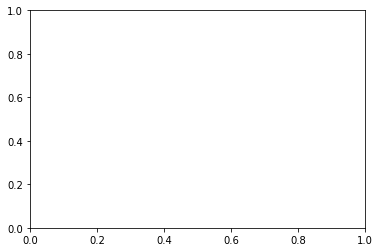

In [3]:
fig, ax1 = plt.subplots()
ax1.plot(trap_df.Date, trap_df.NumMosquitos)

plt.xticks(rotation='vertical', fontsize=7)
plt.legend(loc=2)
for d in wnvDates:
    plt.axvline(d, ymax=0.04, c='r')

ax2 = ax1.twinx()
ax2.plot(trap_df.Date, trap_df.Tavg, c='orange')
plt.legend()

In [ ]:
df['LatAndLong'] = df.apply(lambda x: str(x.Latitude) +', ' + str(x.Longitude), axis=1)

### Working on function to check if a trap affected by spray

In [ ]:
from geopy.distance import distance
from datetime import datetime as dt
from datetime import timedelta

def CheckSprayed( 
            trap_latitude, 
            trap_longitude, 
            spray_latitude,
            spray_longitude, 
            trap_date,
            spray_date,
            distance_limit, 
            days_limit, 
            gestation_days):

    dist_bool = False
    days_bool = False
        
    trap_l = (trap_latitude, trap_longitude)
    spray_l = (spray_latitude, spray_longitude)
    dist = distance(trap_l, spray_l).miles
    
    if dist < distance_limit:
        dist_bool = True
        
    trap_dt = dt.strptime(trap_date, "%Y-%m-%d")
    spray_dt = dt.strptime(spray_date, "%Y-%m-%d")
    if spray_dt + timedelta(days=gestation_days) < trap_dt < spray_dt + timedelta(days=gestation_days) + timedelta(days=days_limit):
        days_bool = True
    
    isSprayed = dist_bool & days_bool
    return isSprayed
    #print(isSprayed)

In [ ]:
# testing of function
trap_longitude = df.Longitude.iloc[0]
trap_latitude = df.Latitude.iloc[0]
spray_longitude = spray_df.Longitude.iloc[0]
spray_latitude = spray_df.Latitude.iloc[0]
trap_date = df.Date.iloc[0]
spray_date =  spray_df.Date.iloc[0]
distance_limit = 50
days_limit = 7
gestation_days = 14
CheckSprayed(trap_latitude, trap_longitude, spray_latitude, spray_longitude, 
        trap_date, spray_date, distance_limit, days_limit, gestation_days)

In [ ]:
# for index, row in df.iterrows():
#     if row > mean:
#         print (index)

In [ ]:
# Trying out date time functionality
trap_dt = dt.strptime(trap_date, "%Y-%m-%d")
spray_dt = dt.strptime(spray_date, "%Y-%m-%d")

trap_dt < spray_dt

a = spray_dt 
c = spray_dt + timedelta(days = 700) 
b = trap_dt+ timedelta(days = 2700)

a < c < b

## Work on creating apply to calculate "IsSprayed" column

In [ ]:
df['IsSprayed'] = 1

#### Something isn't working right with my function...

In [ ]:
trap = df.iloc[5000, :]
dist_lim = 2000
day_lim = 2000
gest_days = 1

chkspraylist = []

for sp_index, spray in spray_df.iterrows():
    chkspray = CheckSprayed(trap.Latitude,
                 trap.Longitude, 
                 spray.Latitude,
                 spray.Longitude,
                 trap.Date,
                 spray.Date,
                 dist_lim,
                 day_lim,
                 gest_days
                )
    chkspraylist.append(chkspray)

print(sum(chkspraylist))
    

#### Turns out there is only 10 days of spray data...  Let's find out which days

In [ ]:
spray_df.Date.value_counts()

In [ ]:
min(spray_df[spray_df.Date == '2013-08-15'].Latitude), max(spray_df[spray_df.Date == '2013-08-15'].Latitude)

In [ ]:
min(spray_df[spray_df.Date == '2013-08-15'].Longitude), max(spray_df[spray_df.Date == '2013-08-15'].Longitude)

In [ ]:

mapdata = np.loadtxt("west_nile/west_nile/input/mapdata_copyright_openstreetmap_contributors.txt")
traps = df[['Date', 'Trap','Longitude', 'Latitude', 'WnvPresent']]

aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

plt.figure(figsize=(10,14))
plt.imshow(mapdata,
          cmap=plt.get_cmap('gray'),
          extent=lon_lat_box,
          aspect=aspect)

spray_df = spray_df[spray_df['Longitude']>-88]
locations = traps[['Longitude', 'Latitude']].drop_duplicates().values
sprays = spray_df[['Longitude', 'Latitude']].drop_duplicates().values

sprays = spray_df[spray_df.Date == '2013-08-15'][['Longitude', 'Latitude']].values

plt.scatter(sprays[:,0], sprays[:,1], c='r', alpha=1)
plt.scatter(locations[:,0], locations[:,1], marker='x')


# Setting up a quick workflow

## Keep only relevant columns

In [ ]:
cols_keep = ['Date','Species','Latitude','Longitude','NumMosquitos','Tavg', 'WnvPresent']

df = df[cols_keep]

In [ ]:
df.head(1)

## Feature Engineering

#### Create boolean - WnvSpecies
- Discussion - Should we make it like this, or split out by species?
- I think we should set up the data for neural net?

In [ ]:
wnvspeciesmap = {
    'CULEX PIPIENS/RESTUANS': 1,
    'CULEX RESTUANS': 1,
    'CULEX PIPIENS': 1,
    'CULEX TERRITANS': 0,
    'CULEX SALINARIUS': 0,
    'CULEX TARSALIS': 0,
    'CULEX ERRATICUS': 0,
    'UNSPECIFIED CULEX':1
}

df['WnvSpecies'] = df.Species.map(wnvspeciesmap)

#### Extract Month from Date

In [ ]:
df['Month'] = df.Date.str[5:7]

#### Set up process for one-hot encoding

In [ ]:
df = pd.get_dummies(df, columns=['Month', 'Species'])

#### Drop Date Column

In [ ]:
cols_to_drop = ['Date']

df = df[[col for col in df.columns if col not in cols_to_drop]]


In [ ]:
df.head()

### Split up Features and Target Variables

In [ ]:
target = 'WnvPresent'
features = [col for col in df.columns if col != target]
y = df[target]
X = df[features]

### Train Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify=y)

### Use Standard Scalar

In [ ]:
ss = StandardScaler()
X_train_ss = pd.DataFrame(ss.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_ss = ss.transform(X_test)

### Over-sample the minority class?

In [ ]:
y_train.value_counts()

In [ ]:
num_oversample = y_train.value_counts()[0]-y_train.value_counts()[1]
num_oversample

In [ ]:
num_oversample = int(num_oversample/5)
num_oversample

In [ ]:
df2 = X_train_ss.copy()
df2['target'] = y_train

In [ ]:
df2.shape

In [ ]:
index_to_add = np.random.choice(df2[df2.target==1].index,size=num_oversample)

oversampling = df2.loc[index_to_add,:]
df_os = pd.concat([df2, oversampling])

In [ ]:
df_os.target.value_counts()

## Split X and y again

In [ ]:
X_train_os = df_os.drop('target',axis=1)
y_train_os = df_os['target']

-----------------------

### Create simple model

In [ ]:
lr = LogisticRegression()
lr.fit(X_train_ss, y_train)
lr.score(X_train_ss, y_train), lr.score(X_test_ss, y_test)

In [ ]:
get_metrics(lr.predict(X_test_ss), y_test)

## Try modeling using oversampled data

In [ ]:
lr = LogisticRegression()
lr.fit(X_train_os, y_train_os)
lr.score(X_train_os, y_train_os), lr.score(X_test_ss, y_test)

In [ ]:
get_metrics(lr.predict(X_test_ss), y_test)

## Try Neural Network??

In [ ]:
X_train.shape

In [ ]:
model = Sequential()
model.add(Dense(18, activation='relu', input_dim=X_train.shape[1])) #Makes this dynamic
model.add(Dense(20, activation='relu')) #Makes this dynamic
model.add(Dense(1, activation=None))

In [ ]:
adam = Adam(lr=0.01)
model.compile(loss='mean_squared_error', optimizer=adam, metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=32)

In [ ]:
plt.plot(history.history['loss'], label= 'Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')

plt.legend()

In [ ]:
plt.plot(history.history['acc'], label='Train Accuracy')
plt.plot(history.history['val_acc'], label='Test Accuracy')
plt.legend()

## Check out Max's work

In [ ]:
codes = {code: [0]*weather_df.shape[0] for codes in weather_df.CodeSum.unique() for code in codes.split()}


weather_df = weather_df.join(pd.DataFrame(codes))
for i, codesum in enumerate(weather_df.CodeSum):
    for code in codesum.split():
        weather_df.at[i, code] = 1
        

codes_df = weather_df.groupby('Date', as_index=True)[list(codes.keys())].max()
# df = df.join(codes_df, on='Date', rsuffix="_code_")

In [ ]:
codes_df = weather_df.groupby('Date', as_index=True)[list(codes.keys())].max()

In [ ]:
codes_df.head()

In [ ]:
df.join(codes_df, on='Date', rsuffix="_code_")

In [ ]:
df.dtypes

In [ ]:
codes_df.index = codes_df.Date

In [ ]:
codes_df.head()